# ACTIVATION FUNCTIONS

<br>

## Introduction

<br>
In artificial neural networks (ANN), <b>the results of the summation function is usually passed through a non-linear function known as the activation function</b> (or transfer function). The activation function is extremely important because <b>it determines whether a neuron should be activated or not</b>; in other words, whether or not to transmit the signal to the next layer of the network.


<br>
<a id='artificial_neuron'>
    <img src="images/artificial_neuron.jpg" alt="artificial neuron" width="45%" height="45%">
</a>

<br>
Without an activation function, the signal transmitted along the axon would simply be a linear trasnformation of weights and bias. Another way to think about it : without a non-linear activation function, no matter how many layers it has, the ANN would behave just like a single-layer perceptron, because summing these layers would yield just another linear function.


## Desirable Properties 

<br>
In this notebook we will see that there are a number of common activation functions in use with neural networks; all of which have (to a greater or lesser extent) the following properties.

<br>
<b>Non Linearity</b> : a linear equation is simple to solve but is limited in its capacity to solve complex problems. <b>The purpose of the activation function is to introduce non-linearity into the neural network, allowing us to model a response variable that varies non-linearly with the explanatory variables</b>.

<br>
<b>Continuously differentiable</b> :
This property is <b>necessary for enabling gradient-based optimization methods</b>. For example, the binary step activation function is not differentiable at 0, and it differentiates to 0 for all other values, so gradient-based methods can make no progress with it.

<br>
<b>Range</b> : when the range of the activation function is finite, gradient-based training methods tend to be more stable, because pattern presentations significantly affect only limited weights. When the range is infinite, training is generally more efficient because pattern presentations significantly affect most of the weights. In the latter case, smaller learning rates are typically necessary.

<br>
<b>Monotonic</b> : when the activation function is monotonic, <b>the error surface associated with a single-layer model is guaranteed to be convex</b>.

<br>
<b>Approximates identity near the origin</b> : when the activation function has this property, the neural network will learn efficiently when the weights are initialized with small random values. When the activation function does not approximate identity near the origin, special care must be used when initializing the weights.


In [1]:
# SETUP : importing

import numpy as np
import math
import pandas as pd

from sklearn.datasets import load_boston

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

import sklearn.neural_network as nn
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import sklearn.metrics as mtr
from scipy import stats

import utilcompute as uc
import utilplot as up
import preprocessing as pre
import regularized_regression as rr

from scipy import stats
import sklearn.metrics as mtr
from statsmodels.stats import diagnostic

import error_metrics as em

from pprint import pprint


C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_boston().data, load_boston().target) )
df = pd.DataFrame(data)
df.columns = [
    'CRIM',    # per capita crime rate by town
    'ZN',      # proportion of residential land zoned for lots over 25,000 sq.ft.
    'INDUS',   # proportion of non-retail business acres per town
    'CHAS',    # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    'NOX',     # nitric oxides concentration (parts per 10 million)
    'RM',      # average number of rooms per dwelling
    'AGE',     # proportion of owner-occupied units built prior to 1940
    'DIS',     # weighted distances to five Boston employment centres
    'RAD',     # index of accessibility to radial highways
    'TAX',     # full-value property-tax rate per $10,000
    'PTRATIO', # pupil-teacher ratio by town
    'B',       # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    'LSTAT',   # % lower status of the population
    'MEDV'     # median value of owner-occupied homes in $1000's
]


In [3]:
# SETUP : printing aggregated info

#s = uc.summary(df)
#print(s)

In [4]:
target = 'MEDV'

if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [5]:
#fig, axs = plt.subplots(nrows = len(features), ncols = 1, figsize=(20, 4 * len(features)))    

#for (f_index, f) in enumerate(features) :
#    ax = axs[f_index]
#    subset = df[f]        
#    sns.distplot(a= subset, ax = ax, label = f)   
#    ax.axvline(x = subset.mean(), linestyle='--')
#    ax.legend(loc='best') 

#plt.tight_layout()
#plt.show()

In [6]:
# SHUFFLING 

seed = 10
np.random.seed(seed)

df = df.reindex(np.random.permutation(df.index))


In [7]:
# SETUP : data split

train_perc = 0.8
delimiter = int(len(df) * train_perc)

df_train = pd.DataFrame( df[:delimiter] ) # train + validation
df_test = pd.DataFrame( df[delimiter:] )  # test


In [8]:
# DATA PREPROCESSING (TRAIN + VALIDATION) : features transformation

excluded_features = ['CHAS']
included_features = [f for f in features if (f not in excluded_features)]

df_cnt = pre.center(df = df_train, included = included_features, excluded = uc.concatenate(excluded_features,target))
df_std = pre.standardize(df = df_train, included = included_features, excluded = uc.concatenate(excluded_features,target))


In [9]:
# DATA PREPROCESSING (TEST) : features transformation

df_cnt_test = pre.center(df = df_test, included = included_features, excluded = uc.concatenate(excluded_features,target))
df_std_test = pre.standardize(df = df_test, included = included_features, excluded = uc.concatenate(excluded_features,target))


In [10]:
def compute_kfold_stats(df, features, target, module, model_name, model_args, note, task, debug = False):
    
    return_conditions = (
        (df.empty) or
        (not features) or
        (not target) or
        ( isinstance(target, list) and len(target) > 1) or
        (not module) or
        (not model_name) or
        (not note) or
        (not task) 
    )
    if (return_conditions):
        return
    
    if (isinstance(target, list)):
        target = target[0]
    
    n_splits = 10
    kf = KFold(n_splits = n_splits, shuffle = False, random_state = None)    
      
    columns = [
        'model_name', 'note', 'iteration', 
        'intercepts', 'coefs',
        'residuals', 'res_normality', 'res_homoscedasticity'
        # error metrics defined dynamically
    ]
    
    results_list = []    
    
    for k, (train_positions, test_positions) in enumerate(kf.split(X = df[features], y = df[target])) :
        
        fold_train = df.iloc[train_positions]   
        fold_test = df.iloc[test_positions]     
        
        if (debug and k == 0):
            print()
            print('iteration {0}   |   len(fold_train) : {1}   |   len(fold_test) : {2}   |   test_positions : [{3} - {4}]'
                  .format(k, len(fold_train), len(fold_test), test_positions[0], test_positions[-1]))   
             
        model_class_ = getattr(module, model_name)
        if (model_args):
            model = model_class_(**model_args)
        else:
            model = model_class_()      
        
        model.fit(fold_train[features], fold_train[target])       
        
        #if(note == 'original'):
        #    print(model.loss_curve_)
        #    plt.plot(model.loss_curve_, label = note)            
                   
        y_pred_train = model.predict(fold_train[features])
        y_pred_test = model.predict(fold_test[features])
        
        if (debug):
            if (k == 0):
                print()
                print('fold_train[target] | type : {0} | shape : {1}'.format(type(fold_train[target]), fold_train[target].shape))
                print('y_pred_train       | type : {0} | shape : {1}'.format(type(y_pred_train), y_pred_train.shape))
                print()
                print('fold_test[target]  | type : {0} | shape : {1}'.format(type(fold_test[target]), fold_test[target].shape))
                print('y_pred_test        | type : {0} | shape : {1}'.format(type(y_pred_test), y_pred_test.shape))
        
        residuals_train = (fold_train[target] - y_pred_train)
        residuals_test = (fold_test[target] - y_pred_test)
        
        if (debug and k == 0):
            print()
            print('residuals_train | type : {0} | shape : {1}'.format(type(residuals_train), residuals_train.shape))
            print('residuals_test  | type : {0} | shape : {1}'.format(type(residuals_test), residuals_test.shape))    
        
        res_normality = stats.shapiro(residuals_test)[0]
        res_homoscedasticity = diagnostic.het_breuschpagan(resid = residuals_test, exog_het = fold_test[features])[3]

        if (task == 'regression'):
            err_metrics_train = em.compute_regression_metrics(y = fold_train[target], y_pred = y_pred_train)            
            err_metrics_test = em.compute_regression_metrics(y = fold_test[target], y_pred = y_pred_test)
        elif (task == 'classification'):
            err_metrics_train = em.compute_classification_metrics(y = fold_train[target], y_pred = y_pred_train, labels = None)
            err_metrics_test = em.compute_classification_metrics(y = fold_test[target], y_pred = y_pred_test, labels = None)
            
        values_dict = {
            'model_name'    : model_name,
            'note'                 : note,
            'iteration'            : k + 1,       
            
            'intercepts'           : model.intercepts_, 
            'coefs'                : model.coefs_,
            
            'residuals'            : residuals_test,
            'res_normality'        : res_normality,
            'res_homoscedasticity' : res_homoscedasticity
        }
        
        # useful for plotting the coefficients across some other discriminant 
        
        #for (f_index, f) in enumerate(features):
        #    values_dict[f] = model.coef_[f_index]
            
        if (debug and k == 0):
            print()
            print('iteration  : {0}'.format(values_dict['iteration']))
            print('intercepts : {0}'.format(values_dict['intercepts']))
            print('coefs      : {0}'.format(values_dict['coefs']))
        
        for (key, value) in err_metrics_train.items():
            values_dict[key] = value
            
        results_list.append(values_dict)        
                
    results_df = pd.DataFrame.from_dict(data = results_list, orient = 'columns')
    
    ordered_columns = uc.concatenate(columns, [c for c in results_df.columns.values.tolist() if (c not in columns)])
    results_df = results_df[ordered_columns]

    #results_df = results_df.astype(dtype = 'float')
    #plt.legend()    
    return results_df

## Binary Step

<br>
The (binary) step function is commonly used in <b>primitive neural networks with or without hidden layers</b>, respectively <b>kwown as single (or multi) layer perceptrons</b>. 

<br>
$
    \quad
    \begin{align}
        \operatorname{f}(x) \quad
        &=  \quad
            \begin{cases}
                \ 0 \quad & \text{if} \ x < 0
                \\ \\
                \ 1 \quad & \text{if} \ x \geq 0
            \end{cases} 
        \qquad \qquad \qquad
        \operatorname{f}'(x) \quad 
        = \quad 
            \begin{cases}
                \ 0 \quad \text{if} \ x \neq 0
                \\ \\
                \ ? \quad \text{if} \ x = 0
            \end{cases} 
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad & [\textbf{E1}]                
    \end{align}
$

<br>
Single layer perceptrons can solve any problem that can be described in terms of a linear combination of the independent variables; in other words, it's able to classify all linearly separable problems (such as the AND/OR gates), where the classes can be separated by a single straight line.

<br>
Multi layer perceptrons, which are provided with hidden layers, can classify non-linearly separable problems as well (such as the XOR gates). In the pictures below, the examples of the AND/OR and XOR gates implemented by single and multi layer perceptrons :


<br>
<table>
    <tr>
        <td width='59%' bgcolor='white'>
            <a id='activation_function_step_2'>
                <img src="images/activation_function_step_2.png" alt="AND OR step thresholds">
            </a>
        </td>
        <td width='41%' bgcolor='white'>
            <a id='activation_function_step_4'>
                <img src="images/activation_function_step_4.png" alt="XOR step threshold">
            </a>
        </td>
    </tr>
</table>


<br>
When dealing with a single class and/or we assume the data to be linearly separable, a step activation function would be the best choice, as it would either activate the neuron or leave it to zero. 


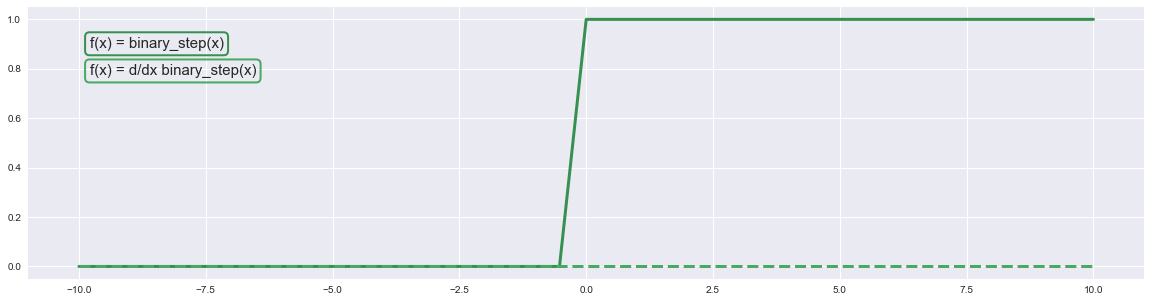

In [11]:
import artificial_neural_networks as ann
ann.plot_activation_functions(cmd = 'binary_step')


<br>
However, the step function has one major drawback : at the moment, one of the most efficient ways to train a multi-layer neural network is by using gradient descent with backpropagation, which requires the activation functions to be continuously differentiable. Unfortunately, <b>the step function is non-differentiable at the origin and it has derivative zero elsewhere</b>; this means that gradient descent won’t be able to make a progress in updating the weights and backpropagation will fail.

<br>
That’s why, sigmoid function and hyperbolic tangent function are common activation functions in practice because their derivatives are easy to demonstrate.


## Linear

<br>
The linear function is a straight line function where <b>the output is proportional to the input</b> (which in turn is, we remember, the output of the summation function) :

<br>
$
    \quad
    \begin{align}
        \operatorname{f}(x)  \quad = \quad a \cdot x 
        \qquad \qquad \qquad
        \operatorname{f}'(x) \quad = \quad a 
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad & [\textbf{E2}]                
    \end{align}
$

<br>
Unlike the simple step function, <b>the linear function not only yields a range of activations</b> (it's not constrained to some binary co-domain), <b>but it also is continuously differentiable</b>.


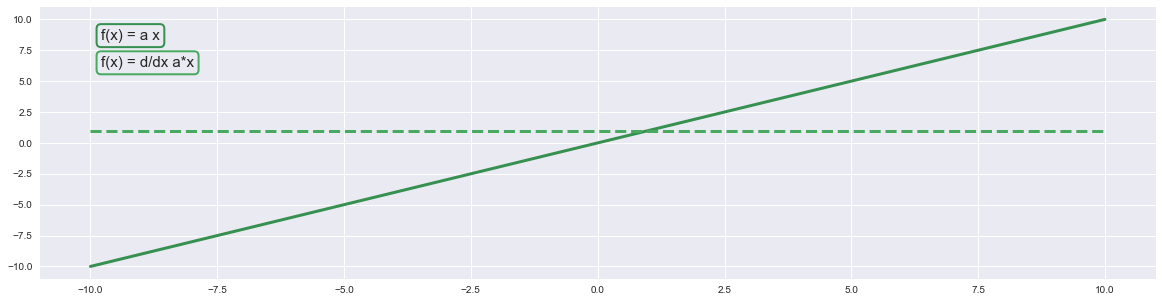

In [12]:
ann.plot_activation_functions(cmd = 'linear')

<br>
Again, the linear function has some non-trivial issues as well. <b>The derivative of the linear function is constant, meaning it has no relationship with the input</b>. Every time back-propagation is performed, the descent is going to be on the same, constant gradient; put another way, when there is an error in prediction, the changes made by back-propagation are constant and independent of the input. <b>Being the gradient pretty much the same at every iteration, we are not really improving the error</b>.

<br>
The second issue is that of complexity (or lack thereof), let's consider a multi layer scenario; it does not matter how many layers we have, if all are linear in nature, the final output is nothing but a linear transformation of the input of the first layer. In such a scenario, the whole neural network can be replaced by a single layer.

<br>
Linear activation functions might be <b>ideal for simple tasks where interpretability is highly desired and complexity can be sacrificed</b>.


In [13]:
ann_list = [
    { 'df' : df_train, 'module' : nn, 'model_name' : 'MLPRegressor', 
      'model_args' : { 'activation': 'identity', 'learning_rate_init' : 0.01}, 'note' : 'original' },
    # { 'df' : df_sk, ''module' : nn, 'model_name' : 'MLPRegressor', 
    #   'model_args' : { 'activation ': 'identity', 'learning_rate_init' : 0.01}, 'note' : 'un-skewed' },
    { 'df' : df_cnt, 'module' : nn, 'model_name' : 'MLPRegressor', 
      'model_args' : { 'activation': 'identity', 'learning_rate_init' : 0.01}, 'note' : 'centered' },
    { 'df' : df_std, 'module' : nn, 'model_name' : 'MLPRegressor', 
      'model_args' : { 'activation': 'identity','learning_rate_init' : 0.01}, 'note' : 'standardized'}    
]

results = pd.DataFrame()

for l in ann_list:
    results_temp = compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        module = l['module'],
        model_name = l['model_name'], 
        model_args = l['model_args'],
        note = l['note'],
        task = 'regression',
        debug = False
    )
    results = results.append(results_temp).reset_index(drop = True)
    

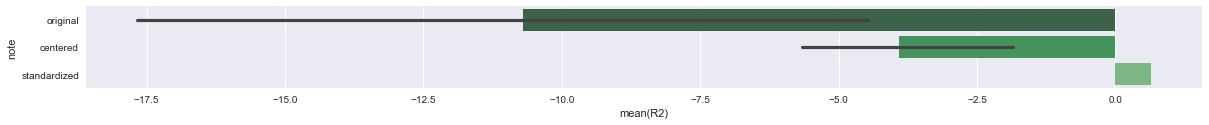

R2 mean (original)       :                           -10.6971
R2 mean (centered)       :                            -3.9002
R2 mean (standardized)   :                             0.6439


In [14]:
metric = 'R2'

up.plot_across_discriminant(
    df = results, 
    cols = [metric], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear activation function', 'skewness' : False, 'normality' : False}, 
    distplot = False,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)


discriminant_values = results['note'].unique().tolist() 
template = "{0:25}:{1:>35}" 
for (d_index,d) in enumerate(discriminant_values):
    label = ('{0} mean ({1})'.format(metric, d))    
    criteria = (results['note'] == d)    
    subset = results[criteria][metric]        
    print(template.format(label, round(subset.mean(), 4)))

## Sigmoid Functions

<br>
A sigmoid function is a <b>bounded, differentiable, real function</b> that is defined for all real input values and has a <b>non-negative first derivative</b> at each point.

<br>
In general, sigmoid functions are <b>monotonically increasing</b> (most often) from 0 to 1 or alternatively from −1 to 1, depending on the convention. Constrained by a pair of <b>horizontal asymptotes</b>, sigmoid functions have a characteristic 'S-shaped' curve, also known as sigmoid curve.

<br><br>
<a id='sigmoid_functions'>
    <img src="images/sigmoid_functions.png" alt="sigmoid functions" width="45%" height="45%">
</a>

<br>
A wide variety of sigmoid functions have been used as the activation function of artificial neurons, including the logistic and hyperbolic tangent functions, which we will see shortly.


## [S1] Sigmoid Logistic

<br>
The sigmoid logistic function is a special case of the logistic function having a characteristic 'S-shaped' curve. Formally, the the logistic function is defined by the formula below, where $e$ is the natural logarithm base, $x_0$ is the x-value of the sigmoid midpoint, $L$ is the curve maximum value, and $k$ is the steepness of the curve :

<br>
$
    \quad \operatorname{l}(x) = \dfrac{L}{1 + e^{-k (x - x_0)}}
$

<br>
By setting $L = 1$, $k = 1$, and $x_0 = 0$ we derive the sigmoid logistic function, also simply known as the sigmoid function :

<br>
$
    \quad
    \begin{align}
        \operatorname{f}(x)  \quad = \quad \dfrac{1}{1 + e^{-x}}
        \qquad \qquad \qquad
        \operatorname{f}'(x) \quad = \quad \operatorname{f}(x) \cdot \left[ \ 1 – \operatorname{f}(x) \ \right] 
        \qquad \qquad \qquad \qquad \qquad \qquad 
        \qquad \qquad \qquad \qquad \qquad \qquad \quad & [\textbf{E3}]                
    \end{align}
$


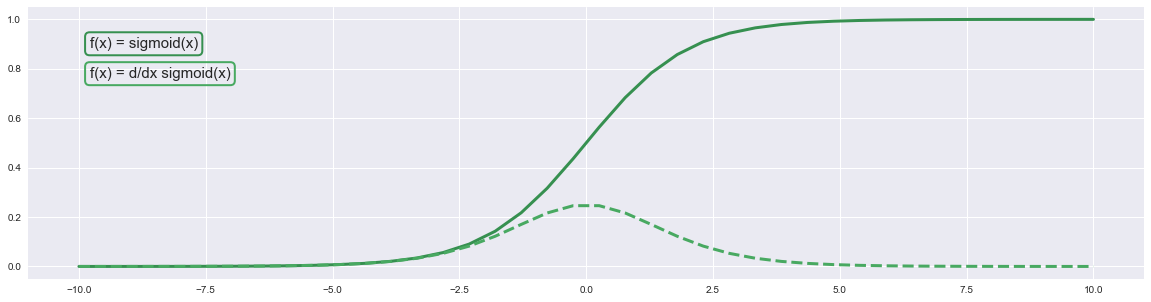

In [15]:
ann.plot_activation_functions(cmd = 'sigmoid_logistic')

<b>Advantages</b>
<br>

<br>
Beside the sigmoid function being continuously differentiable and bounded, <b>the biggest advantage it has over the step and linear functions is non-linearity</b>; this essentially means that when we have multiple neurons all having the sigmoid function as their activation function, the output is non-linear as well. We can now build multi layer ANN able to address <b>non-linear tasks</b>.

<br>
Looking at the plot, we notice that the gradient is almost flat at the asymptotes and grows more and more as we get closer to the center; in this region the values of the sigmoid function grow quite steeply, which means that small changes in the value of the input would bring about significant changes in the value of the activation. We could say <b>the sigmoid function has a tendency to push the activation values towards either end of the curve</b> (i.e. the asymptotes), which is a very desirable quality when trying to classify the values to a particular class, because it would yield more clear distinctions on predictions.

<br>
<b>Disadvantages</b>
<br>

<br>
Since the sigmoid function is nearly flat at the asymptotes, in these two regions of the domain the gradient is approximately zero. This characteristic of the sigmoid curve gives rise to a problem known as <a id='vanishing_gradients'><b>vanishing gradients</b></a> : during back-propagation, the neurons with a gradient comparable to zero are called "saturated neurons" (or said to be in a saturation state), and the weights in these neurons do not update. Not only that, but the weights of neurons connected to such neurons are also slowly updated. In conclusion, <b>the value of the gradient in saturated neurons is so small (or vanished) that gradient descent cannot make any significant change to the weights; the network refuses to learn further or is drastically slow</b>. There are ways to work around this problem and sigmoid is still very popular in classification problems.

<br>
The <b>activation values</b> yielded by the sigmoid function <b>are not zero-centered</b>, which is an undesirable feature given the implications on the dynamics during gradient descent. If the data coming into a neuron is always positive (e.g. $ x > 0$ element-wise in $ f(x) = w^{T}x + b $), then the gradient on the weights during back-propagation will become either all positive, or all negative (depending on the gradient of the whole expression $f$). This could introduce <b>undesirable zig-zagging dynamics in the gradient updates for the weights</b>; however, once these gradients are added up across a batch of data the final update for the weights can have variable signs, somewhat mitigating this issue. Therefore, this is an inconvenience but it has less severe consequences compared to the saturated activation problem.

<br>
The exponential function is computationally expensive compared with other non-linear activation functions.


In [16]:
logistic_list = [
    { 'df' : df_train, 'module' : nn, 'model_name' : 'MLPRegressor', 
      'model_args' : { 'activation': 'logistic', 'learning_rate_init' : 0.01}, 'note' : 'original' },
    # { 'df' : df_sk, ''module' : nn, 'model_name' : 'MLPRegressor', 
    #   'model_args' : { 'activation ': 'logistic', 'learning_rate_init' : 0.01}, 'note' : 'un-skewed' },
    { 'df' : df_cnt, 'module' : nn, 'model_name' : 'MLPRegressor', 
      'model_args' : { 'activation': 'logistic', 'learning_rate_init' : 0.01}, 'note' : 'centered' },
    { 'df' : df_std, 'module' : nn, 'model_name' : 'MLPRegressor', 
      'model_args' : { 'activation': 'logistic','learning_rate_init' : 0.01}, 'note' : 'standardized'}    
]

results = pd.DataFrame()

for l in logistic_list:
    results_temp = compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        module = l['module'],
        model_name = l['model_name'], 
        model_args = l['model_args'],
        note = l['note'],
        task = 'regression',
        debug = False
    )
    results = results.append(results_temp).reset_index(drop = True)
    

C:\Users\danis_p50\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


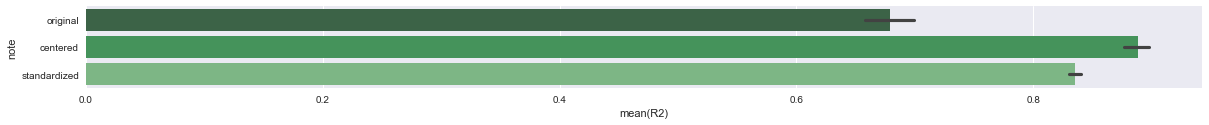

R2 mean (original)       :                             0.6791
R2 mean (centered)       :                             0.8885
R2 mean (standardized)   :                             0.8351


In [17]:
metric = 'R2'

up.plot_across_discriminant(
    df = results, 
    cols = [metric], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'sigmoid logistic activation function', 'skewness' : False, 'normality' : False}, 
    distplot = False,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)


discriminant_values = results['note'].unique().tolist() 
template = "{0:25}:{1:>35}" 
for (d_index,d) in enumerate(discriminant_values):
    label = ('{0} mean ({1})'.format(metric, d))    
    criteria = (results['note'] == d)    
    subset = results[criteria][metric]        
    print(template.format(label, round(subset.mean(), 4)))

## [S2] Hyperbolic Tangent

<br>
In neural networks, the hyperbolic tangent function ($\text{tanh}$) is an alternative to the to sigmoid logistic function, compared to which it can be interpreted as a scaled version. 

<br>
$
    \quad
    \begin{align}
        \operatorname{f}(x)   
        \quad = \quad \operatorname{tanh}(x)
        \quad = \quad \dfrac {(e^{x} - e^{-x})} {(e^{x} + e^{-x})}   
        \quad = \quad 2 \ \operatorname{sigmoid}(2x) - 1
        \qquad \qquad \qquad
        \operatorname{f}'(x) \quad = \quad 1 - {\operatorname{f}(x)}^2
        \qquad \qquad \qquad \qquad \qquad \quad & [\textbf{E4}]                
    \end{align}
$


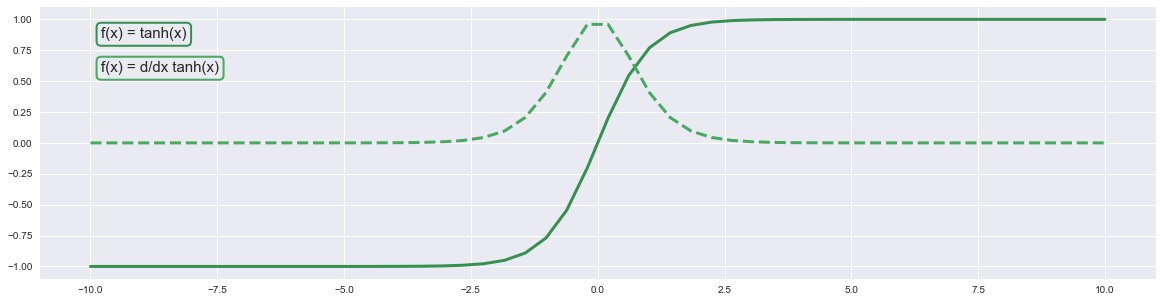

In [18]:
ann.plot_activation_functions(cmd = 'sigmoid_hyperbolic_tangent')

<b>Advantages</b>
<br>

<br>
Being sigmoidal itself, the hyperbolic tangent preserves <b>all the advantages that the sigmoid logistic curve has over the step and linear functions</b> : it is <b>continuously differentiable, bounded</b> and, most important, <b>non-linear</b>. 

<br>
Unlike sigmoid logistic, <b>the activation values of the hyperbolic tangent function are symmetric around the origin</b>, which makes it preferable over the former. 

<br>
One point to mention is that <b>the gradient is stronger for <i>tanh</i> than for sigmoid</b>, meaning the curve is steeper in the first case. Negative and positive inputs correspond to (respectively) strongly negative and positive outputs, while zero input values are mapped near zero. Deciding between the sigmoid or $\text{tanh}$ will also depend on your requirement of gradient strength.

<br>
<b>Disadvantages</b>
<br>

<br>
The only drawback of the hyperbolic tangent function is that, <b>just like the sigmoid logistic, it also suffers from vanishing gradients</b> and therefore kills gradients when saturated.


In [19]:
hyperbolic_tan_list = [
    { 'df' : df_train, 'module' : nn, 'model_name' : 'MLPRegressor', 
      'model_args' : { 'activation': 'tanh', 'learning_rate_init' : 0.01}, 'note' : 'original' },
    # { 'df' : df_sk, ''module' : nn, 'model_name' : 'MLPRegressor', 
    #   'model_args' : { 'activation ': 'tanh', 'learning_rate_init' : 0.01}, 'note' : 'un-skewed' },
    { 'df' : df_cnt, 'module' : nn, 'model_name' : 'MLPRegressor', 
      'model_args' : { 'activation': 'tanh', 'learning_rate_init' : 0.01}, 'note' : 'centered' },
    { 'df' : df_std, 'module' : nn, 'model_name' : 'MLPRegressor', 
      'model_args' : { 'activation': 'tanh','learning_rate_init' : 0.01}, 'note' : 'standardized'}    
]

results = pd.DataFrame()

for l in hyperbolic_tan_list:
    results_temp = compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        module = l['module'],
        model_name = l['model_name'], 
        model_args = l['model_args'],
        note = l['note'],
        task = 'regression',
        debug = False
    )
    results = results.append(results_temp).reset_index(drop = True)
    

C:\Users\danis_p50\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


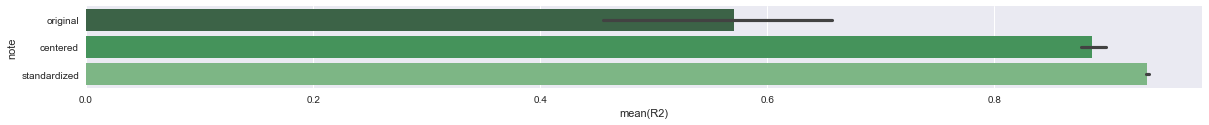

R2 mean (original)       :                             0.5708
R2 mean (centered)       :                             0.8859
R2 mean (standardized)   :                             0.9348


In [20]:
metric = 'R2'

up.plot_across_discriminant(
    df = results, 
    cols = [metric], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'sigmoid hyperbolic tan activation function', 'skewness' : False, 'normality' : False}, 
    distplot = False,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)


discriminant_values = results['note'].unique().tolist() 
template = "{0:25}:{1:>35}" 
for (d_index,d) in enumerate(discriminant_values):
    label = ('{0} mean ({1})'.format(metric, d))    
    criteria = (results['note'] == d)    
    subset = results[criteria][metric]        
    print(template.format(label, round(subset.mean(), 4)))

## Rectified Linear Unit (ReLU)

<br>
ReLu (Rectified Linear Unit) is the most used activation function in ANN at the time of writing this notebook; it is a <b>monotonic, continuously differentiable, half-bounded, non-linear</b> function defined as :

<br>
$
    \quad
    \begin{align}
        \operatorname{f}(x)   
        \quad = \quad \operatorname{max}(0,x)
        \quad = \quad
            \begin{cases}
                \ 0 \quad & \text{if} \ x < 0
                \\ \\
                \ x \quad & \text{if} \ x \geq 0
            \end{cases}
        \qquad \qquad \qquad
        \operatorname{f}'(x) 
        \quad = \quad 
            \begin{cases}
                \ 0 \quad & \text{if} \ x < 0
                \\ \\
                \ 1 \quad & \text{if} \ x \geq 0
            \end{cases}
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad & [\textbf{E5}]                
    \end{align}
$

<br>
As you can see from the picture below, ReLU is half-rectified from the bottom, which means that negative inputs are mapped to zero, and non-negative inputs are mapped directly into activation values.


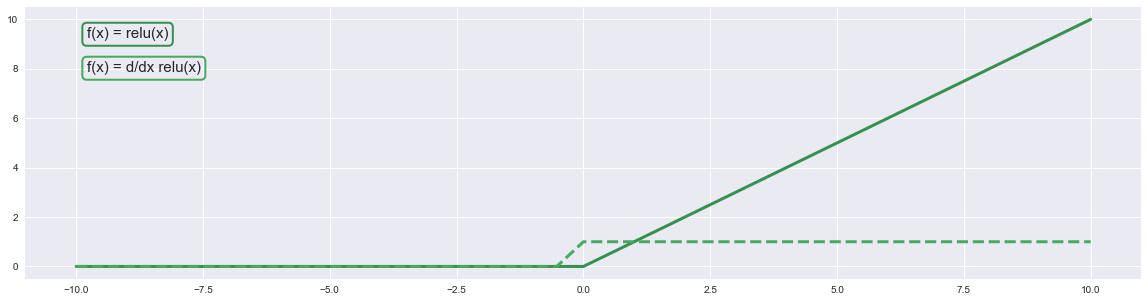

In [21]:
ann.plot_activation_functions(cmd = 'relu')

<b>Advantages</b>
<br>

<br>
The first feature of ReLU that is worth taking into consideration is <b>continuous differentiability</b>: our artificial neural network, unlike binary step or linear activation functions, can actually implement gradient-based optimization methods such as back-propagation.

<br>
Another feature ReLU shares with both the sigmoid functions we have seen so far (sigmoid logistic and hyperbolic tangent) is <b>non-linearity</b> which means, as we have already discussed in this notebook, that we can structure our neural network into multiple layers and solve non-linear problems. 

<br>
Another relevant point is the <b>sparsity of the activation</b>. Let's consider a big neural network with a large number of neurons; using sigmoid or tanh will cause almost all neurons to fire (by transmitting an analog activation value). That means almost all activations will be processed to describe the output of a network. In other words, the activation is said to be "dense", which is expensive in terms of computational resources and/or time. Ideally, we would want a few neurons in the network to not activate and thereby making the activations "sparse" and more efficient.

<br>
The first advantage of ReLu over sigmoidal curves comes from the fact that it is only <b>partially bounded</b>. This type of activation was found to <b>greatly accelerate the convergence of stochastic gradient descent compared to saturating non-linearities</b> like sigmoid and tanh (<a href="http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf">Krizhevsky et al., 2012 </a>).

<br>
The second advantage of ReLU is that it can be implemented using simple thresholding at zero, making it <b>more computationally efficient</b>, compared to sigmoid/tanh activation functions that involve expensive operations (exponentials, etc).

<br>
<b>Disadvantages</b>
<br>

<br>
ReLu is great, but nothing is flawless. It's easy to see that the threshold immediately maps any negative values to zero, which decreases the ability of the model to fit or train from the data properly. Shortly, we will see that this is not the main issue the threshold brings about. 

<br>
Because of the horizontal line, the gradient can go towards zero (at least for negative inputs). We discussed the issue of <a href='#vanishing_gradients'>vanishing gradients</a> and we know that, for activation values in that region of ReLU, gradient descent won't be able to make any significant change to the weights. Those <b>neurons which go into that state will stop responding to variations in error/input</b>; this issue, known as <b>"dying ReLu"</b>, can cause several neurons to just die and not respond, <b>making a substantial part of the network passive</b>. 

<br>
Variations of ReLU were developed in order to mitigate this issue by choosing a non-horizontal, slightly inclined line for the negative region of the domain (see Leaky ReLU). There are other variations too, but the main idea is to let the gradient be non- zero and recover during training eventually.

<br>
A final consideration : the <b>activation values are not zero-centered</b>.


In [22]:
relu_list = [
    { 'df' : df_train, 'module' : nn, 'model_name' : 'MLPRegressor', 
      'model_args' : { 'activation': 'relu', 'learning_rate_init' : 0.01}, 'note' : 'original' },
    # { 'df' : df_sk, ''module' : nn, 'model_name' : 'MLPRegressor', 
    #   'model_args' : { 'activation ': 'relu', 'learning_rate_init' : 0.01}, 'note' : 'un-skewed' },
    { 'df' : df_cnt, 'module' : nn, 'model_name' : 'MLPRegressor', 
      'model_args' : { 'activation': 'relu', 'learning_rate_init' : 0.01}, 'note' : 'centered' },
    { 'df' : df_std, 'module' : nn, 'model_name' : 'MLPRegressor', 
      'model_args' : { 'activation': 'relu','learning_rate_init' : 0.01}, 'note' : 'standardized'}    
]

results = pd.DataFrame()

for l in relu_list:
    results_temp = compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        module = l['module'],
        model_name = l['model_name'], 
        model_args = l['model_args'],
        note = l['note'],
        task = 'regression',
        debug = False
    )
    results = results.append(results_temp).reset_index(drop = True)
    

C:\Users\danis_p50\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


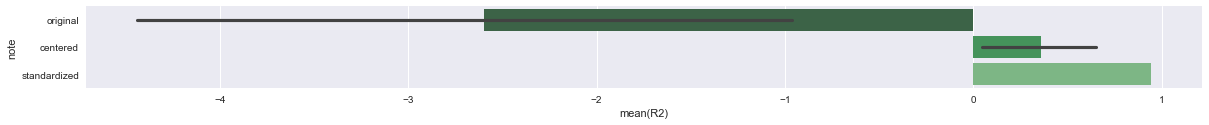

R2 mean (original)       :                            -2.5972
R2 mean (centered)       :                             0.3601
R2 mean (standardized)   :                             0.9423


In [23]:
metric = 'R2'

up.plot_across_discriminant(
    df = results, 
    cols = [metric], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'relu activation function', 'skewness' : False, 'normality' : False}, 
    distplot = False,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)


discriminant_values = results['note'].unique().tolist() 
template = "{0:25}:{1:>35}" 
for (d_index,d) in enumerate(discriminant_values):
    label = ('{0} mean ({1})'.format(metric, d))    
    criteria = (results['note'] == d)    
    subset = results[criteria][metric]        
    print(template.format(label, round(subset.mean(), 4)))

## Leaky ReLU

<br>
Leaky ReLU is an <b>improved version of ReLU</b>, designed as an attempt to mitigate the problem of dying neurons. Instead of the function being zero in the negative region of the domain, Leaky ReLU will instead have a <b>small negative slope</b> (usually 0.01) :

<br>
$
    \quad
    \begin{align}
        \operatorname{f}(x)   
        \quad = \quad
            \begin{cases}
                \ 0.01 \cdot x \quad & \text{if} \ x < 0
                \\ \\
                \ x \quad & \text{if} \ x \geq 0
            \end{cases}
        \qquad \qquad \qquad
        \operatorname{f}'(x) 
        \quad = \quad 
            \begin{cases}
                \ 0.01 \quad & \text{if} \ x < 0
                \\ \\
                \ 1 \quad & \text{if} \ x \geq 0
            \end{cases}
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad & [\textbf{E6}]                
    \end{align}
$


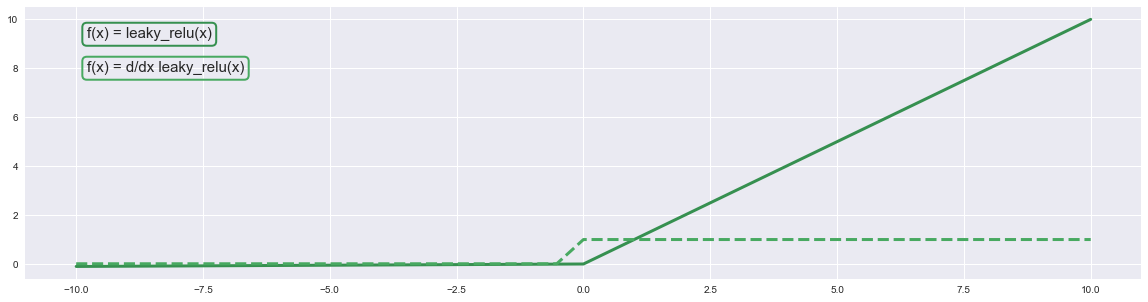

In [24]:
ann.plot_activation_functions(cmd = 'leaky_relu')

<br>
<b>Replacing the horizontal line</b> not only helps to increase the range of the ReLU function, but also <b>seems to eliminate the issue of dying neurons</b> (although <b>the consistency of the benefit across tasks remains unclear</b>).  

<br>
It's worth pointing out that <b>Leaky ReLU preserves all the nice properties of ReLU</b> : non-saturating non-linearity, fast convergence, computational efficiency.


## Parametric ReLU

<br>

<br>
The idea of Leaky ReLU can be extended even further; instead of multiplying the input by a constant term we can use a hyperparameter. This extension to leaky ReLU is known as Parametric ReLU.

<br>
The network will learn (through back-propagation) the value of the hyperparemter for which it obtains faster and more optimal convergence.

<br>
$
    \quad
    \begin{align}
        \operatorname{f}(x)   
        \quad = \quad
            \begin{cases}
                \ a \cdot x \quad & \text{if} \ x < 0
                \\ \\
                \ x \quad & \text{if} \ x \geq 0
            \end{cases}
        \qquad \qquad \qquad
        \operatorname{f}'(x) 
        \quad = \quad 
            \begin{cases}
                \ a \quad & \text{if} \ x < 0
                \\ \\
                \ 1 \quad & \text{if} \ x \geq 0
            \end{cases}
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad & [\textbf{E7}]                
    \end{align}
$

<br>
Parametric ReLU is used when Leaky ReLU still fails to solve the problem of dead neurons and the relevant information is not successfully passed to the next layer.


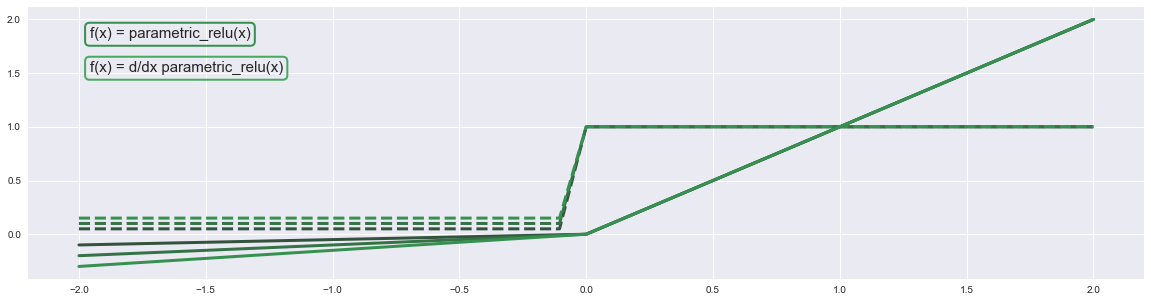

In [25]:
ann.plot_activation_functions(cmd = 'parametric_relu')

## Choosing the proper Activation Function

<br>
Now that we have seen a number of activation  functions, it would be great to know which activation function should be used in which situation. Needless to say, there is no rule of thumb; however, depending upon the properties of the problem we might be able to make a better choice for easy and quicker convergence of the network.

<br>
When we know the function that we are trying to approximate has certain characteristics, we can choose an activation function which will approximate the function faster, leading to faster training process : <b>sigmoid functions and their combinations generally work better in the case of classifiers, but saturating sigmoidal curves are often avoided due to the problem of vanishing gradients</b>.

<br>
<b>When we don't know the nature of the function we are trying to learn, it would probably be better to start with ReLu</b>, which works most of the time as a general approximator, <b>and then move over to other activation functions</b> in case ReLU doesn’t provide with optimum results or the network appears to be affected by a relevant number of dead neurons.


## References

<br>
<ul style="list-style-type:square">
    <li>
         Wikipedia - 
         <a href="https://bit.ly/2fE7id7">
         Activation Function</a>        
    </li>
    <br>
    <li>
         WikiBooks - 
         <a href="https://bit.ly/1ibQ047">
         Activation Functions</a>        
    </li>
    <br>
    <li>
         Analytics Vidhya - 
         <a href="https://bit.ly/2lcKkxe">
         Fundamentals of Deep Learning : Activation Functions and When to Use Them</a>        
    </li>
    <br>
    <li>
         Medium - Towards Data Science - 
         <a href="https://bit.ly/2ntXyn8">
         Activation Functions : Neural Networks</a>        
    </li>
    <br>
    <li>
         Medium - The Theory Of Everything - 
         <a href="https://bit.ly/2wv3kcd">
         Understanding Activation Functions in Neural Networks</a>        
    </li>
    <br>
    <li>
         StackOverflow - CrossValidated - 
         <a href="https://bit.ly/2sqtJ9r">
         Why is step function not used in activation functions in machine learning ?</a>        
    </li>
    <br>
    <li>
         Sefik Ilkin Serengil - 
         <a href="https://bit.ly/2JcCfDw">
         Step Function as a Neural Network Activation Function</a>        
    </li>
    <br>
    <li>
         All About Analytics - 
         <a href="https://bit.ly/2H2TqlR">
         Activation Functions in ANNs (Part 1)</a>        
    </li>
    <br>
    <li>
         Wikipedia - 
         <a href="https://bit.ly/2g4tslH">
         Sigmoid Function</a>        
    </li>
    <br>
    <li>
         Isaac Changhau - 
         <a href="https://bit.ly/2IVYluH">
         Activation Functions in Artificial Neural Networks</a>        
    </li>
    <br>
    <li>
         Learn OpenCV - 
         <a href="https://bit.ly/2JgiXx2">
         Understanding Activation Functions in Deep Learning</a>        
    </li>
    <br>
    <li>
         Sefik Ilkin Serengil - 
         <a href="https://bit.ly/2sh1Otg">
         Sigmoid Function as Neural Network Activation Function</a>        
    </li>
    <br>
    <li>
         Sefik Ilkin Serengil - 
         <a href="https://bit.ly/2H0lSVy">
         Hyperbolic Tangent as Neural Network Activation Function</a>        
    </li>
</ul>

<br>
<table>
    <tr>
        <td width='40%' bgcolor='white'>
            <a id='perceptron_rule'>
                <img src="images/learning_algorithms_perceptron_rule.png" alt="perceptron rule">
            </a>
        </td>
        <td width='40%' bgcolor='white'>
            <a id='adaline_rule'>
                <img src="images/learning_algorithms_adaline_rule.png" alt="adaline rule">
            </a>
        </td>
    </tr>
</table>